# 검증용 데이터셋 준비

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
print('complete')

complete


In [7]:
# 검증용 데이터셋 경로 
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'

In [8]:
file_list = os.listdir(work_dir)

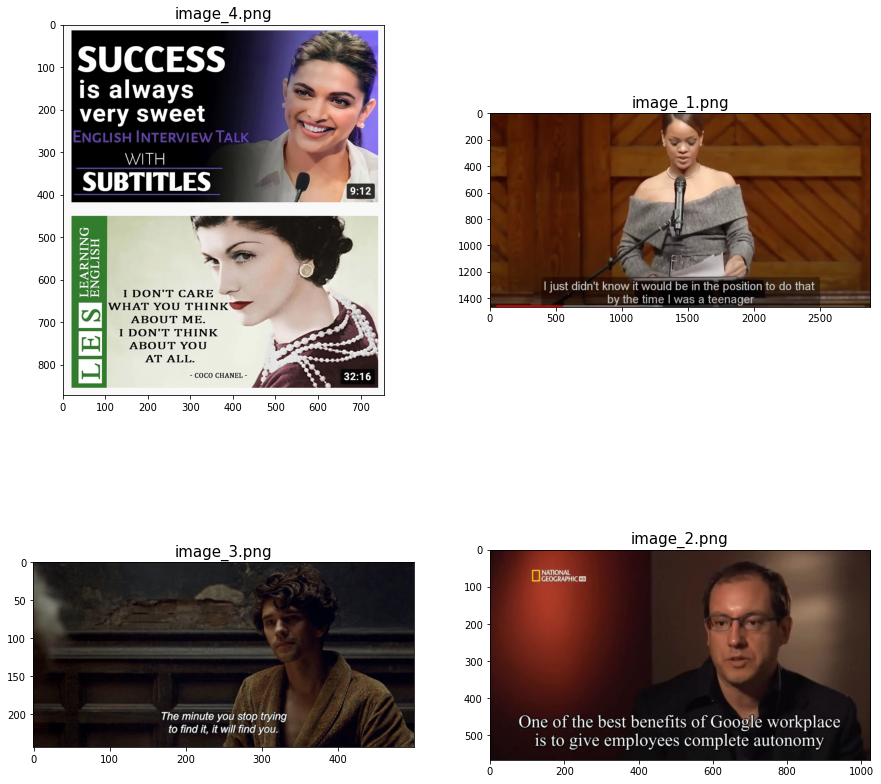

In [9]:
# 검증용 데이터셋 시각화
plt.figure(figsize=(15,15))
i=0
for file in file_list:
    plt.subplot(2,2,i+1)
    image_files = os.path.join(work_dir, file)
    image = cv2.imread(image_files)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    i += 1
    plt.title(file, fontsize=15)
    plt.imshow(image)

# keras-ocr, Tesseract로 테스트 진행

### keras-ocr

In [10]:
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [11]:
# text detect을 한 뒤 dictionary에 append 
images = []
prediction_groups = []
keras_ocr_dict = {}
for i, file in enumerate(file_list):    
    image_files = os.path.join(work_dir, file)
    images.append(keras_ocr.tools.read(image_files)) 
    prediction_groups.append(pipeline.recognize([image_files]))
    
    text_list = []
    for j in range(len(prediction_groups[i][0])):
        text_list.append(prediction_groups[i][0][j][0])
        
    keras_ocr_dict[file] = text_list

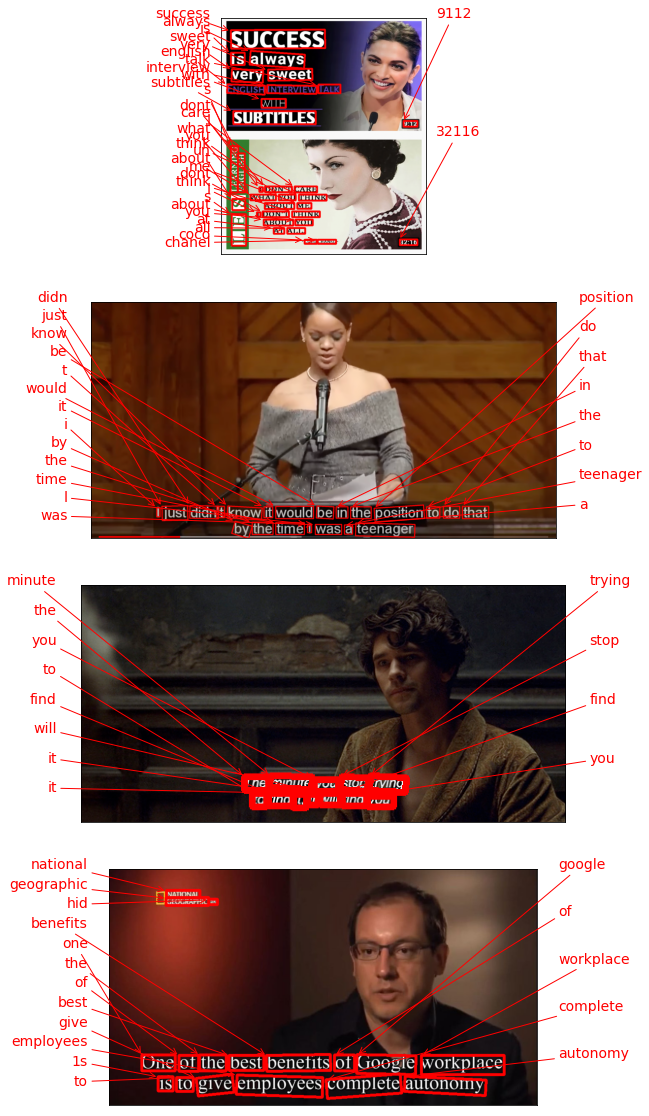

In [12]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [18]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            #print(output_img_path) #return값이 쓸데없이 길게 나와서 주석처리
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [19]:
#work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
#img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

#cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

In [20]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 dictionary에 append
def recognize_images(cropped_image_path_list, file):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    text_list = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng', # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text_list.append(recognized_data['text'].replace('\n\x0c',''))
        
    print(f"{file} -  Done")
    
    return text_list

In [21]:
tesseract_dict = {}
for i, file in enumerate(file_list):
    image_files = os.path.join(work_dir, file)
    output_dir = work_dir + '/output_' + str(i)
    cropped_image_path_list = crop_word_regions(image_files, output_dir)   
    tesseract_dict[file] = recognize_images(cropped_image_path_list, file)

image_4.png -  Done
image_1.png -  Done
image_3.png -  Done
image_2.png -  Done


# 테스트 결과 정리

In [22]:
# 검증용 데이터셋 시각화 함수
def image_show(idx):
    plt.figure(figsize=(8, 10))
    image_files = os.path.join(work_dir, file_list[idx])
    image = cv2.imread(image_files)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image)

Keras-ocr : 
 ['didn', 't', 'just', 'know', 'would', 'be', 'do', 'that', 'i', 'it', 'in', 'the', 'position', 'to', 'the', 'by', 'time', 'teenager', 'l', 'was', 'a']
Tesseract : 
 ['\x0c', '|', 'eR', 'dian t', 'KNOW', 'i', 'ViVelelle', 'ne', 'Ta', 'the', 'position', 'tO', 'do', 'that', '»!', 'the', 'time', '|', 'Was', 'Pa |', 'teenager', '—  ———_ ——_—']


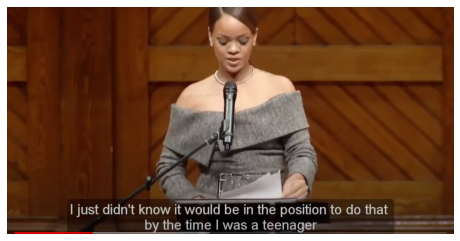

In [31]:
image_show(1)
print(f"Keras-ocr : \n {keras_ocr_dict['image_1.png']}")
print(f"Tesseract : \n {tesseract_dict['image_1.png']}")

Keras-ocr : 
 ['national', 'geographic', 'hid', 'one', 'the', 'benefits', 'of', 'google', 'of', 'best', 'workplace', 'employees', 'complete', '1s', 'give', 'to', 'autonomy']
Tesseract : 
 ['SF', '\x0c', 'Oars', 'eye', 'the', 'best', 'benefits', 'of', 'Google', 'workplace', 'ts', 'tO', 'ae', 'employees', 'complete', 'autonomy']


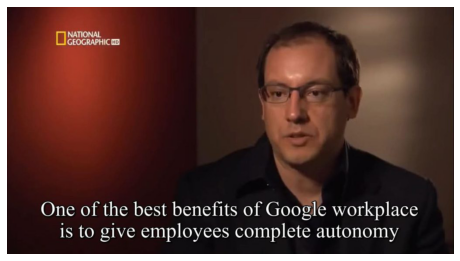

In [32]:
image_show(3)
print(f"Keras-ocr : \n {keras_ocr_dict['image_2.png']}")
print(f"Tesseract : \n {tesseract_dict['image_2.png']}")

Keras-ocr : 
 ['the', 'minute', 'stop', 'trying', 'you', 'to', 'find', 'will', 'find', 'it', 'it', 'you']
Tesseract : 
 ['\x0c']


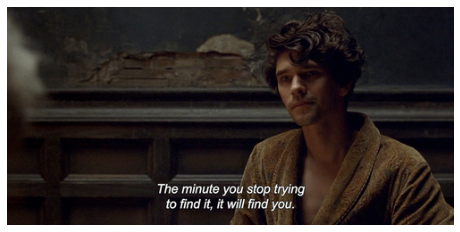

In [33]:
image_show(2)
print(f"Keras-ocr : \n {keras_ocr_dict['image_3.png']}")
print(f"Tesseract : \n {tesseract_dict['image_3.png']}")

Keras-ocr : 
 ['success', 'always', 'is', 'sweet', 'very', 'english', 'talk', 'interview', 'with', 'subtitles', '9112', 's', '', 'dont', 'care', 'l', 'what', 'you', 'think', 'un', 'about', 'me', 'dont', 'think', 'l', 's', 'about', 'you', 'at', 'all', 'coco', 'chanel', '32116']
Tesseract : 
 ['SUCCESS', 'rs)', '| |', 'Ways', 'very', 'aay', 'ViVA oe', 'SUBTITLES', 'i', '\x0c', '\x0c', '|', "DON'T", '( ARE', '———_', 'WHAT', 'YOU', 'THINK W@W.', 'ABOUT', 'Mi EF...', '+‘.', 'I', 'DONT', 'THINK', 'ae', 'ABOUT', 'YOt', 'ts', '—', 'rN', '. =', 'LOCO', 'CHANEL', '”', '\x0c', 'es") eS', 'a', 'es']


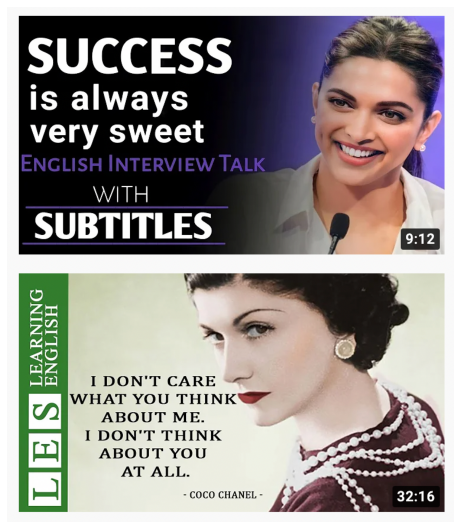

In [34]:
image_show(0)
print(f"Keras-ocr : \n {keras_ocr_dict['image_4.png']}")
print(f"Tesseract : \n {tesseract_dict['image_4.png']}")

# 결과 분석과 결론 제시

여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.   
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.   
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

서비스의 목적: 시각 장애인들을 위해 외국어 영상에 삽입된 자국어 자막을 음성 합성 시스템(Text to Speech)을 사용하여 음성 정보로 변환한다.

서비스의 내용: 영상 편집 과정에서 영상 자체에 이미지로써 삽입된 자막을 인식해내 텍스트로 변환하여 TTS 기능을 통해 음성 정보로 변환한다.
(smi등 별도 자막 파일로 분리되지 않은 영화의 자막이나, 유튜브에서 유튜브 자막 기능을 활용하지 않은 영상 자체 자막 등에 활용이 가능하다.)

평가기준:   
대전제 - 정성적 평가를 진행한다.
1.이미지에서 주어, 서술어, 목적어, 보어에 해당하는 핵심 단어를 제대로 인식하는가?(수식어는 보통 문장 의미에 크게 영향을 주지 않으므로)
즉, 정확하게 인식한 단어만으로 자막 속 문장의 본래 의미를 어느정도 왜곡 없이 전달할 수 있는가?
2.여러가지 자막 스타일(자막바의 유무, 산세리프/세리프 폰트, 이탤릭체)에 대해서 보편적인 성능을 내는가?   

결과 분석:   
Keras-ocr   
자막 스타일의 차이, 자막 폰트의 차이, 이미지 크기의 차이에 좌우되지 않는 좋은 성능을 보였다.   
꽤 작은 크기의 image_3.png 속 자막 내용과 image_4.png 속 -COCO CHANEL- 글씨까지 정확하게 인식한다.   
대소문자 구별은 하지 못하지만 음성 정보로 변환할 때 크게 중요하지 않은 정보이므로 상관 없다.   
Tesseract   
모든 이미지에 대해 생각보다 많이 떨어지는 성능을 보였다.   
특히 작은 크기의 image_3.png의 경우 아예 글씨를 인식하지 못하는 모습을 보였다.   
이번 Exploration 본문에서 한글로 이루어진 test_image.png를 사용해서 결과가 잘 나오지 않았나 생각했는데, 영어로 된 이미지들에도 그닥 성능이 좋지 않은 것을 보아 추가적인 처리가 필요한가 생각이 든다.   
   
결론적으로 모든 이미지에 대해 좋은 성능을 보여준 keras-ocr모델을 채택한다.

# 회고

이번 노드는 지금까지 해왔던 과제 중 가장 힌트가 없는 Exploration이라고 생각해 두려움이 앞섰다. 다른 말로 본문에서 긁어다 파라미터 조금 바꿔가는 식으로 과제를 제출해온 내 정수리에 메다 꽂힌 날벼락이라고도 할 수 있겠다. 그래도 뭐 어째, 이미 과제를 2번 미제출한 탓에 15개의 Exploration 중 아이펠 수료 기준인 제출률 85%를 넘으려면 이걸 어떻게든 해서 제출해야한다. 오늘까지 아이펠 과정을 달려왔다면 이제 어떻게든 수료 해야지 발 빼기엔 너무 멀리 왔기 때문이다.   
다행히 뭐든 사고 치고 일 만드는 걸 좋아하는 사람이라 기획과 평가기준을 세우는 건 뚝딱이었고, 잘 살펴보니 본문에서 제시한 코드 외에 크게 코딩해야할 것도 (생각보다)없었다. 지난번 어떤 노드에도 썼던 내용같긴 한데, 어렵다 어렵다 하면서도 결국 (단순 본문 코드 복붙이 아닌)내가 뭔가 생각해서 구성해야하는 과제가 다 하고나면 훨씬 뿌듯하고 재미있긴 하다. 그렇다고 희희낙락 과제를 한 건 아니고 여전히 머리는 쥐어 뜯어야 하지만.   
방학 전 마지막 퇴실 QR체크 시간에 재준 퍼실님께서 하루 1시간이라도 매일매일 빼먹지 말고 공부를 유지하는 것이 좋다고 말씀하셨는데, 그건 귓등으로 흘리고 지금까지 print()의 p도 안 보고 있다가 갑자기 과제때문에 노트북을 켜니 머리가 아프다. 이제 다시 누우러 가야지~
